In [ ]:
from sympy import expand, symbols, simplify, factor
import sympy as sp

# State variables 
m1, m2, d1, d2, n1, n2 = symbols('m1 m2 d1 d2 n1 n2', real=True)

# Parameters
wm, wd, Lm, Ld, alpha, beta, uptake_m, uptake_d, gamma_m, gamma_d, gamma_nm, gamma_nd, kappa, R, H = symbols('wm wd Lm Ld alpha beta uptake_m uptake_d gamma_m gamma_d gamma_nm gamma_nd kappa R H', real=True)



h1 = R*H 
h2 = H - h1     
hr2s = 1/3600



#       advection        diffusion       loss      growth
f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + alpha*m1*(n1/(gamma_m + n1))    # surface Microcystis
f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
f3 = -wd/h1*d1  + kappa/h1 * (d2 - d1) - Ld*d1 + beta*d1*(n1/(gamma_d + n1))      # surface diatoms
f4 = wd/h2*d1   + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
f5 = kappa/h1 * (n2 - n1) - uptake_m*m1*(n1/(n1+gamma_nm)) # - d1*uptake_d*(n1/(n1+gamma_nd))     # surface nutrients 
# f6 = 0 
# f6 = kappa/h2 * (n1 - n2)

solution = sp.solve([f1, f2, f3, f4], [m1, m2, d1, d2], dict=True)
solution = sp.solve([f1, f5], [m1,  n1], dict=True)

print(solution)
for i, sol in enumerate(solution):
    print(f"Solution {i+1}:")
    for key, value in sol.items():
        print(f"{key} = {simplify(value)}")
        example = value #.subs({R: 0.5, H: 10, kappa: 1e-3, w: 1e-4, v: 1e-4, Lm:1e-5, Ld:1e-5, growth_m:1e-4, growth_d:1e-4}).evalf()
        # print("\t" , example)


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import cmocean as cmo
cmap = cmo.cm.balance

dst = xr.open_dataset("population_dataset_time_INIT1.nc")

N = len(dst.kappa)
NT = len(dst.t)
print(N)
print(NT)



print(dst)

def jacobian(kappa, h1, h2, m1, m2, n1):

    monod_growth_m = growth_m * n1 / (gamma_m + n1)
    monod_uptake_m = uptake_m *  n1 / (gamma_nm + n1)


    j = np.array([[(-kappa/h1 + monod_growth_m - Lm),   (kappa/h1 + wm/h1),         growth_m*m1*gamma_m/(gamma_m + n1)**2],
                  [kappa/h2,       (-wm/h2 - kappa/h2 - Lm),   0],
                  [monod_uptake_m,   0,  (-kappa/h1 - uptake_m * m1 * gamma_nm/(gamma_nm + n1)**2)]])
    eigenvalues, eigenvectors = np.linalg.eig(j)


    # Sort by eigenvalue 
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return (eigenvalues, eigenvectors)      

15
300
<xarray.Dataset> Size: 24MB
Dimensions:  (t: 300, depth: 15, ratio: 15, kappa: 15)
Coordinates:
  * ratio    (ratio) float32 60B 0.1 0.3071 0.5143 0.7214 ... 2.586 2.793 3.0
  * kappa    (kappa) float32 60B 0.1 0.03728 0.01389 ... 2.683e-07 1e-07
  * depth    (depth) float32 60B 4.0 4.5 5.0 5.5 6.0 ... 9.0 9.5 10.0 10.5 11.0
  * t        (t) int64 2kB 0 120 241 361 482 ... 35518 35639 35759 35880 36000
Data variables:
    m1       (t, depth, ratio, kappa) float64 8MB ...
    m2       (t, depth, ratio, kappa) float64 8MB ...
    n1       (t, depth, ratio, kappa) float64 8MB ...


<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_274925/1443358325.py:31: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Re($\lambda$)")
/tmp/ipykernel_274925/1443358325.py:32: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_274925/1443358325.py:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


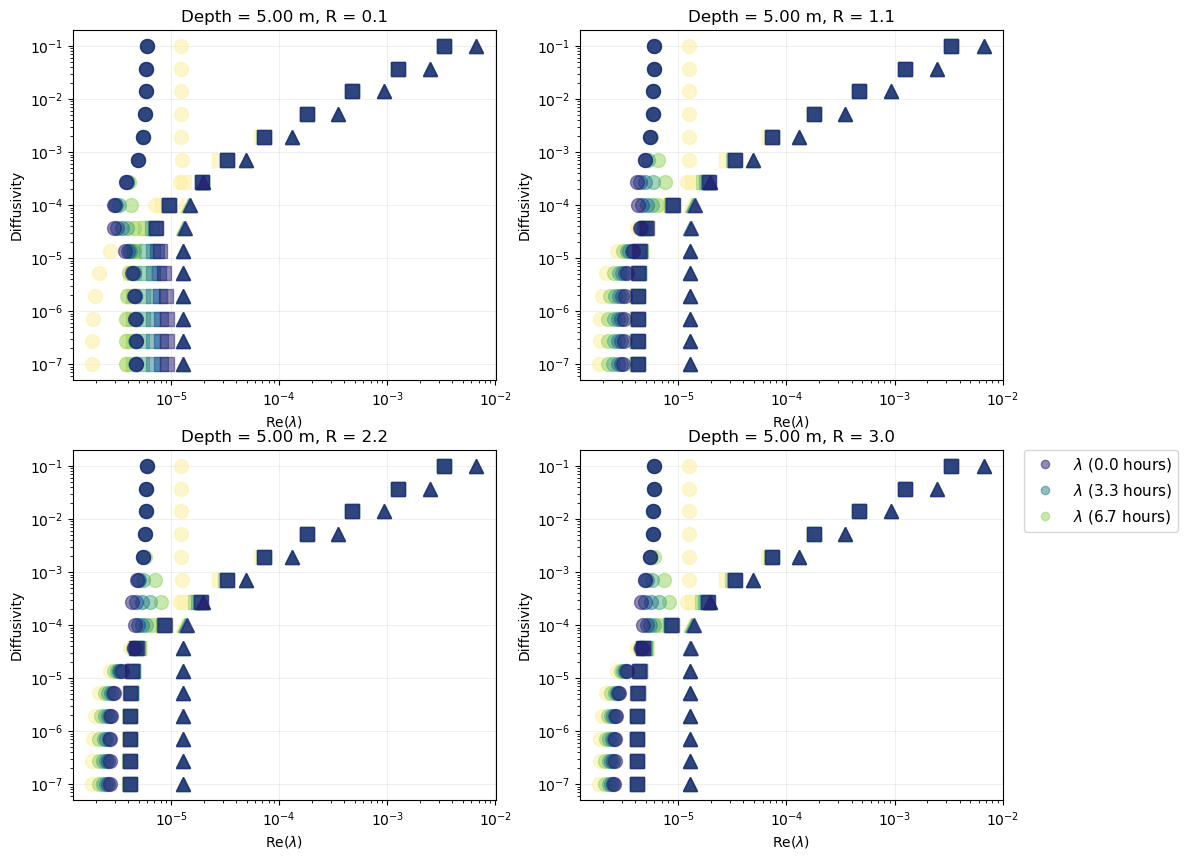

In [ ]:
# Snapshot of three time frames 
TIMES = list(range(0, 300, 50)) 

id = 2
ir = 14

# Depth = 5.00 m, R = 0.6, Kappa = 2e-04 (interesting)
depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
h1 = ratio * depth
h2 = depth - h1

# txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
shapes = ['o', 's', '^', 'x', 'v']
variables = ["M_1", "M_2", "D_1", "D_2", "N_1"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
axs = axs.flatten()

for ax in axs:
    ax.grid(alpha=0.2)
    # ax.legend()
    
    ax.axhline(y=0, color='k', alpha=0.5)
    ax.axvline(x=0, color='k', alpha=0.5)
    ax.set_ylabel("Diffusivity")
    ax.set_xlabel("Re($\lambda$)")
    ax.set_yscale('log')
    ax.set_xscale('log')
irs = [0, 5, 10, 14]
for ix, ax in enumerate(axs):

    ir = irs[ix]
    ratio = dst.ratio.values[ir]
    txt = "Depth = %2.2f m, R = %2.1f" % (depth, ratio)
    ax.set_title(txt)
    for ik in range(0, 15, 1):
        kappa = dst.kappa.values[ik]
            
        for it in TIMES: 
            hour = dst.t.values[it]/3600

            m1 = dst.m1.values[it, id ,ir, ik]
            m2 = dst.m2.values[it, id ,ir, ik]
            n1 = dst.n1.values[it, id ,ir, ik]
            eigenvalues, ev = jacobian(kappa, h1, h2, m1, m2, n1)
            for e, eig in enumerate(eigenvalues):
                if eig.real < 0:
                    eigenvalues[e] = -eig
                    ev[e] = -ev[e]
                
            eigenvalues = sorted(eigenvalues)
            vector0 = np.array([m1, m2, n1])
            color = cmo.cm.haline_r(it/max(TIMES))

            for ie, eigenvalue in enumerate(eigenvalues[0:3]):
                # if eigenvalue.real<0:
                #     vector0 = -vector
                # else:
                #     vector0 = vector
                ev0 = ev[ie]/ np.linalg.norm(ev[ie])
                vector0 = vector0/ np.linalg.norm(vector0)
                if eigenvalue.imag != 0:
                    print("Complex eigenvalue!")
                if ((it%2) == 0):
                    ax.plot(abs(eigenvalue.real), kappa, shapes[ie], color=color, alpha=0.5, markersize=10) #, label=r"$\lambda_%d$ (%2.1f hours)" % (ie, hour), )
                    # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)#,  label=r"$V_%d$ (%2.1f hours)" % (ie, hour))
                else:
                    ax.plot(abs(eigenvalue.real), kappa, shapes[ie],  color=color, alpha=0.5, markersize=10)
                    # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)
                    # print(ev[ie].dot(ev[ie+1])) 

for it in TIMES[::2]:
    hour = dst.t.values[it]/3600
    ax.plot([],[], 'o', alpha=0.5, color = cmo.cm.haline(it/max(TIMES)),  label=r"$\lambda$ (%2.1f hours)" % (hour)) 


ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11,)
fn = txt.replace(",", "_")
# fig.savefig("eigens/%s.png" % fn, dpi=300)


ratio = 1.76
depth = 5.00e+00
kappa = 1.39e-02


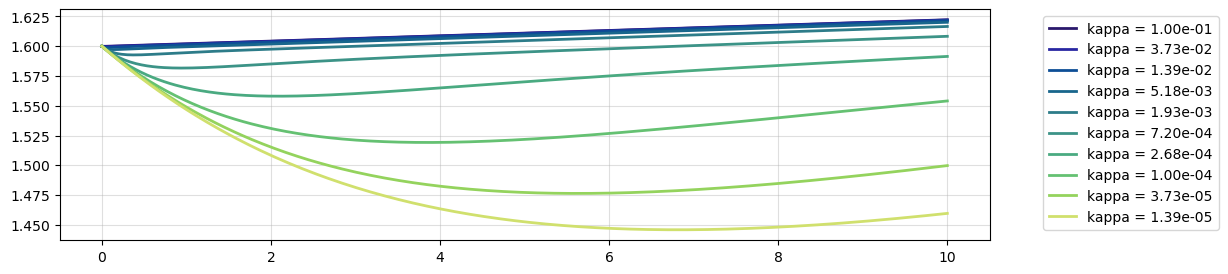

In [ ]:


#   * ratio    (ratio) float32 60B 0.1 0.3071 0.5143 0.7214 ... 2.586 2.793 3.0
#   * kappa    (kappa) float32 60B 0.1 0.03728 0.01389 ... 2.683e-07 1e-07
#   * depth    (depth) float32 60B 4.0 4.5 5.0 5.5 6.0 ... 9.0 9.5 10.0 10.5 11.0
#   * t        (t) int64 2kB 0 36 72 108 144 181 ... 10656 10692 10728 10764 10800
# Data variables:
#     m1       (t, depth, ratio, kappa) float64 8MB ...
#     m2       (t, depth, ratio, kappa) float64 8MB ...
#     n1       (t, depth, ratio, kappa) float64 8MB

fig = plt.figure(figsize=(12, 3))
ax  = plt.gca()
for ir in range(0, 10):
    color = cmo.cm.haline(ir/10)
    ik = 2
    id = 2
    ax.plot(dst.t.values/3600, dst.m1[:, id, 8, ir]/1e6 + dst.m2[:, id, 8, ir]/1e6, 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ir])

print("ratio = %2.2f" % dst.ratio.values[8])

print("depth = %2.2e" % dst.depth.values[ik])
print("kappa = %2.2e" % dst.kappa.values[ik])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.4)

1600000.0


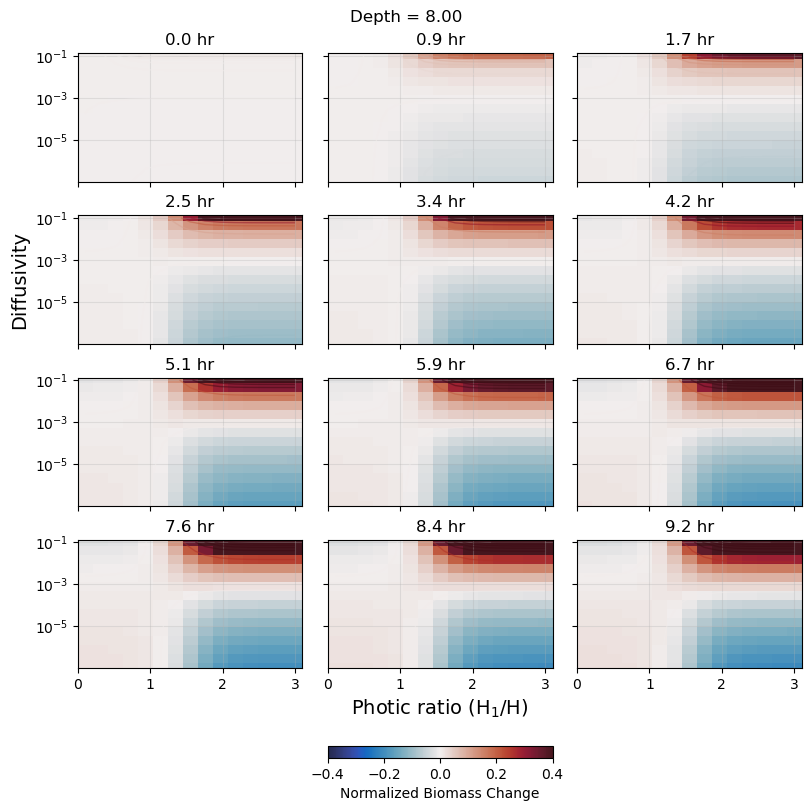

In [ ]:

init_biomass = dst.m1.values[0, 0 ,0,0] + dst.m2.values[0, 0 ,0,0]
print(init_biomass)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()


# norm 
norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


def normalize_color2(value):
    c = (value - init_biomass) / init_biomass
    # c = c.clip(-3, 3)
    return c


def reshape_(data, N):
    return np.array(data).reshape(N, -1)


id = 8
ir = 1
ik = 1
depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 


NT = 300 
for i, it in enumerate(range(1, NT, NT//12)):
    # color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
    axs[i].set_yscale('log')

    axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

    h = axs[i].pcolormesh(RATIO, KAPPA,
                normalize_color2(reshape_(BIOMASS_M, N)), linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=-4e-1, vmax=4e-1) 

    h1 = axs[i].contour(RATIO, KAPPA,
                normalize_color2(reshape_(BIOMASS_M, N)), linewidths=1, alpha=0.5, vmin=-4e-1, vmax=4e-1, cmap=cmo.cm.balance, ) 

plt.colorbar(h, label='Normalized Biomass Change', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)

for ax in axs:
# ax.plot([], [], color=color, label="%2.1f hr" % (dst.t.values[it]/3600), linewidth=4, alpha=0.5)
    # ax.set_xlabel("Photic ratio (H$_1$/H)")
    # ax.set_ylabel("Diffusivity")
    # # ax.legend(ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left', title="Time")
    # ax.set_title("Microcystis")
    ax.grid(alpha=0.3)

1600000.0


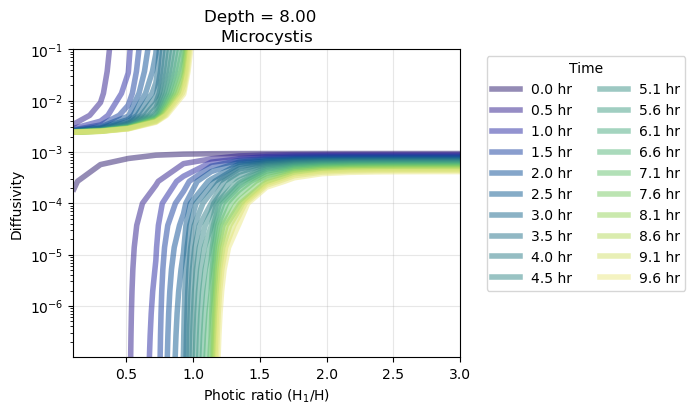

In [ ]:

init_biomass = dst.m1.values[0, 0 ,0,0] + dst.m2.values[0, 0 ,0,0]
print(init_biomass)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

ax.set_yscale('log')

# norm 
norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


def normalize_color2(value):
    c = (value - init_biomass) / init_biomass
    # c = c.clip(-3, 3)
    return c


def reshape_(data, N):
    return np.array(data).reshape(N, -1)


depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 


NT = 300 
for it in range(1, NT, 15):

    color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]

    ax.contour(RATIO, KAPPA,
                normalize_color2(reshape_(BIOMASS_M, N)), levels=[0], linewidths=4, alpha=0.5, colors=color) 

    ax.plot([], [], color=color, label="%2.1f hr" % (dst.t.values[it]/3600), linewidth=4, alpha=0.5)

ax.set_xlabel("Photic ratio (H$_1$/H)")
ax.set_ylabel("Diffusivity")
ax.legend(ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left', title="Time")
ax.set_title("Microcystis")
ax.grid(alpha=0.3)

Text(0.5, 1.0, 'Depth = 6.50 m, Kappa = 3.7e-02, Ratio = 1.1')

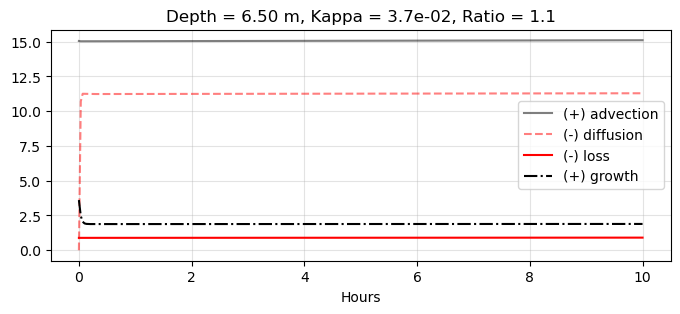

In [ ]:
fig = plt.figure(figsize=(8,3))



id = 5
ir = 5
ik = 1

colors = ["#164F73", "#75A653", "#F2BC79", "#D9665B"]

times = dst.t.values/3600
axp = plt.gca()

depth = dst.depth.values[id]

growth_m = 1.08e-5              # 1/s 
half_sat_m1 = 0.18              # µmol P / L
max_uptake_m1 = 2.23e-12        # µmol P / cell s 
half_sat_n1_m = 1.23            # µmol P / L


ratio = dst.ratio.values[ir]
h1 = depth*ratio
h2 = depth - h1

depth = dst.depth.values[id]
kappa = dst.kappa.values[ik]



kappa = dst.kappa.values[ik]
advection = dst.m2.values[:, id ,ir,ik]*wm/h1 
diffusion = kappa/h1*(dst.m2.values[:, id ,ir,ik] - dst.m1.values[:, id ,ir,ik])

m1 = dst.m1.values[:, id ,ir,ik]
n1 = dst.n1.values[:, id ,ir,ik]

growth = (growth_m * m1*(n1/(half_sat_m1 + n1)))  #growth_m * dst.m1.values[:, id ,ir,ik] *  dst.n1.values[:, id ,ir,ik] 


loss = Lm * dst.m1.values[:, id ,ir*2,ik]
axp.plot(times, advection, '-k', alpha=0.5, label="(+) advection")
axp.plot(times, -diffusion, '--r', label="(-) diffusion", alpha=0.5)
axp.plot(times, loss, '-r', label="(-) loss")
axp.plot(times, growth, '-.k', label="(+) growth")
gl = growth - loss

# axp.set_yscale("log")
axp.set_xlabel("Hours")
axp.grid( alpha=0.35)
axp.legend()
axp.set_title("Depth = %2.2f m, Kappa = %2.1e, Ratio = %2.1f" % (depth, kappa, ratio))


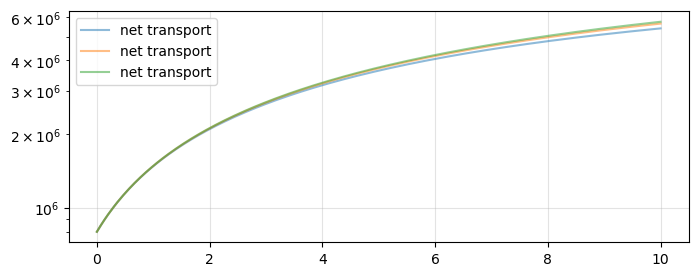

In [ ]:


fig = plt.figure(figsize=(8,3))
id = 1 
ir = 2
ik = 13

colors = ["#164F73", "#75A653", "#F2BC79", "#D9665B"]

axp = plt.gca()

depth = dst.depth.values[id]
for ir in range(0,1):
    ratio = dst.ratio.values[ir*2]
    h1 = depth*ratio
    h2 = depth - h1
    for ik in range(11, 14):
        kappa = dst.kappa.values[ik]

        axp.plot(dst.t.values/3600, dst.m1.values[:, id ,ir*2,ik], '-', alpha=0.5, label="net transport")
        # axp.plot(dst.t.values/3600, -diffusion, '--', label="diffusion", alpha=0.5)

        # gradient = np.gradient(dst.m1.values[:, id ,ir*2,ik], dst.t.values)
        # index = np.where(gradient < 0)[0][0]
        # print("@ kappa = %2.2e" % dst.kappa.values[ik])
        # print("starts dying at t= %2.2f" % (dst.t.values[index]/3600))
        # axp.plot(dst.kappa.values[ik], dst.t.values[index]/3600, 'o', color=colors[ir])
# print(gradient)
axp.set_yscale("log")
# axp.set_ylabel("Hours")
# axp.set_xlabel("Kappa (m/s)")
axp.grid( alpha=0.35)
# axp.set_xlim(0, 40)
axp.legend()

$$ J  = \begin{bmatrix}
    -\frac{\kappa}{H_1} + \alpha \left(\frac{N_1}{\gamma_M + N_1}\right) - L_m & 
    \frac{\kappa}{H_1} +  \frac{w_m}{H_1}  & \alpha M_1 \left( \frac{\gamma_M}{(N_1 + \gamma_M)^2} \right) \\
    \frac{\kappa}{H_2} & -\frac{w_m}{H_2} - \frac{\kappa}{H_2} - L_m 
     & 0  \\
       - U_{m} \left(\frac{N_1}{N_1 + \gamma_{NM}}\right)  & 0  & -\frac{\kappa}{H_1}  - U_M M_1 \left(\frac{\gamma_{NM}}{(N_1 + \gamma_{NM})^2} \right) \\
\end{bmatrix}$$



In [ ]:

    


def steady_state(H, R, kappa, d2, m2, n1):

    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)

    return (d1, m1)
           

def field_at_point(R, H, kappa, m1, m2, n1):
    h1 = R*H 
    h2 = H - h1     
    #       advection        diffusion       loss      growth
    f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + alpha*m1*(n1/(gamma_m + n1))    # surface Microcystis
    f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
    # f3 = -wd/h1*d1  + kappa/h1 * (d2 - d1) - Ld*d1 + beta*d1*(n1/(gamma_d + n1))      # surface diatoms
    # f4 = wd/h2*d1   + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
    f5 = kappa/h1 * (n2 - n1) - uptake_m*m1*(n1/(n1+gamma_nm))   
    

    return f1, f2, f5



def first_deriv(h1, m2, kappa, n1):
    dm1 = ((wm/h1)*m2  + kappa/h1 * (m2)  )/(kappa/h1 + Lm - growth_m*n1)    # surface Microcystis
    print(dm1)


In [ ]:
id = 3
ik = 2
ir = 2

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]

m1 = dst.m1.values[:, id ,ir,ik]
# d1 = dst.d1.values[:, id ,ir,ik]
# d2 = dst.d2.values[:, id ,ir,ik]
m2 = dst.m2.values[:, id ,ir,ik]
n1 = dst.n1.values[:, id ,ir,ik]
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
print("depth = %2.2f, ratio = %2.2f, kappa = %1.0e" % (depth, ratio, kappa))

depth = 5.50, ratio = 0.51, kappa = 1e-02


In [ ]:
def set_up_phase_axes(fig, axs): 
    axs = axs.flatten()

    gs = axs[1].get_gridspec()

    axs[0].remove()
    axs[1].remove()
    axs[2].remove()

    axs[3].remove()
    axs[4].remove()
    axs[5].remove()

    axphase = fig.add_subplot(gs[0:, 0])
    axp = fig.add_subplot(gs[1:3])
    axn = fig.add_subplot(gs[4:6])
    return axphase, axp, axn


0.51428574 5.5 0.013894955 0.0 800000.0 0.0
0.51428574 5.5 0.013894955 1200970.4928177209 800000.0 0.0
0.51428574 5.5 0.013894955 2401940.9856354417 800000.0 0.0
0.51428574 5.5 0.013894955 0.0 800000.0 0.1935
0.51428574 5.5 0.013894955 1200970.4928177209 800000.0 0.1935
0.51428574 5.5 0.013894955 2401940.9856354417 800000.0 0.1935
0.51428574 5.5 0.013894955 0.0 800000.0 0.387
0.51428574 5.5 0.013894955 1200970.4928177209 800000.0 0.387
0.51428574 5.5 0.013894955 2401940.9856354417 800000.0 0.387
0.51428574 5.5 0.013894955 0.0 796595.8882402537 0.0
0.51428574 5.5 0.013894955 1200970.4928177209 796595.8882402537 0.0
0.51428574 5.5 0.013894955 2401940.9856354417 796595.8882402537 0.0
0.51428574 5.5 0.013894955 0.0 796595.8882402537 0.1935
0.51428574 5.5 0.013894955 1200970.4928177209 796595.8882402537 0.1935
0.51428574 5.5 0.013894955 2401940.9856354417 796595.8882402537 0.1935
0.51428574 5.5 0.013894955 0.0 796595.8882402537 0.387
0.51428574 5.5 0.013894955 1200970.4928177209 796595.8882

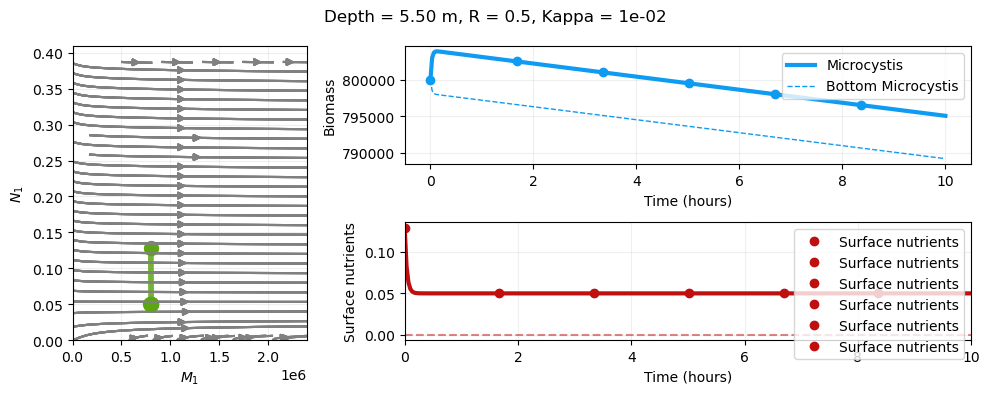

In [ ]:
NN = 3

MM = 2 #largest_val
x = np.linspace(0, max(dst.m1.values[:,0,0,0]), NN)
y = np.linspace(0, max(dst.n1.values[:,0,0,0]), NN)
X, Y = np.meshgrid(x, y)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharey=False, sharex=False)
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
fig.suptitle("Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa))
axphase, axp, axn = set_up_phase_axes(fig, axs)

# Plot time series
axn.plot(dst.t.values/3600, dst.n1.values[:, id ,ir,ik], color='#BF0F0F', linewidth=3)


biomass_m = dst.m1.values[:, id ,ir,ik] + dst.m2.values[:, id ,ir,ik]
axp.plot(dst.t.values/3600, dst.m1.values[:, id ,ir,ik], label=r"Microcystis", color='#0F9BF2', linewidth=3)
axp.plot(dst.t.values/3600, dst.m2.values[:, id ,ir,ik], '--', label=r"Bottom Microcystis", color='#0F9BF2', linewidth=1)


axphase.plot(dst.m1.values[0, id ,ir,ik], dst.n1.values[0, id ,ir,ik], '^', color='k', alpha=0.3, linewidth=4)

axphase.grid(alpha=0.2)
axn.grid(alpha=0.2)
axp.grid(alpha=0.2)


axn.set_ylabel("Surface nutrients")
axp.set_ylabel("Biomass")
axp.set_xlabel("Time (hours)")

axn.set_xlabel("Time (hours)")
axn.set_xlim(0, dst.t.values[-1]/3600)
# axp.set_xlim(0, dst.t.values[-1]/3600)
axp.legend(loc='upper right')

axn.hlines(1e-5, 0, dst.t.values[-1]/3600, colors='#BF0F0F', linestyles='dashed', alpha=0.5)


distances = [] 
for it in range(0, 300, 50):

    m1 = dst.m1.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]
    n1 = dst.n1.values[it, id ,ir,ik]

    U, V = np.zeros_like(X), np.zeros_like(Y)

    # Compute derivatives on grid
    for i in range(NN):
        for j in range(NN):
                f1, f2, f5 = field_at_point(ratio, depth, kappa, X[i,j], m2, Y[i,j])
                U[i,j] = f1
                V[i,j] = f5

    axp.plot(dst.t.values[it]/3600, dst.m1.values[it, id ,ir,ik] , 'o', color='#0F9BF2')
    axn.plot(dst.t.values[it]/3600, dst.n1.values[it, id ,ir,ik] , 'o', color='#BF0F0F', label="Surface nutrients")
    axn.legend()
    # axphase.plot([0, MM], [0, MM], '--', color='black', alpha=0.15)
    axphase.set_xlabel(r"$M_1$")
    axphase.set_ylabel(r"$N_1$")
    axphase.plot(dst.m1.values[0:it, id ,ir,ik], dst.n1.values[0:it, id ,ir,ik], '-', color='#5CA612', alpha=0.3, linewidth=4)
    axphase.plot(m1, n1, 'o', color='#5CA612', markersize=10)
    axphase.streamplot(x, y, U, V,  color="gray")
    # d11, m11 = steady_state(depth, ratio, kappa, d2, m2, n1)
    # # axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)
    # distance = np.sqrt((m11 - m1)**2 + (d11 - d1)**2)
    # distances.append(m11)
    plt.tight_layout()
#     plt.show()
#     assert(False)
#     # fig.savefig("gif/t_%03d.png" % it, dpi=150)

#     axphase.cla()
#     for art in list(axphase.lines[1:]):
#         art.remove()
#     for art in list(axn.lines[1:]):
#         art.remove()
#     for art in list(axp.lines[4:]):
#         art.remove()
# plt.close()



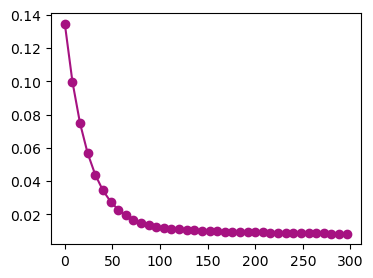

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(0, 300, 8), distances, '-o', color='#A61281')

In [ ]:
import imageio
import os

folder  = "gif/"
images = []
for file_name in sorted(os.listdir(folder)):
    if file_name.endswith('.png'):
        file_path = os.path.join(folder, file_name)
        images.append(imageio.imread(file_path))
imageio.mimwrite('time_evolution_%s.gif' % txt, images, fps=3)
print(txt)

/tmp/ipykernel_1424657/1301611190.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


Depth = 5.00 m, R = 0.4, Kappa = 3e-04
